# Dependancies

## Requirements

In [93]:
#!pip install sentence_transformers langchain openai tqdm datasets asyncio scikit-learn cohere tiktoken umap altair

In [94]:
import numpy as np
import re
import pandas as pd
from tqdm.notebook import tqdm
from datasets import load_dataset
import umap
import altair as alt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from typing import List, Optional
import enum

from langchain_community.llms import Ollama
from langchain.output_parsers.regex_dict import RegexDictParser
from langchain.output_parsers import PydanticOutputParser
from langchain_core.messages import HumanMessage, SystemMessage, ChatMessage
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from pydantic import BaseModel, Field, validator, create_model
from openai import AsyncOpenAI, OpenAI
#import asyncio
import os
from typing import Tuple, List, Optional

import requests

from pydantic import BaseModel, ValidationInfo, model_validator

import json

import itertools
from copy import deepcopy
from tqdm.notebook import tqdm, trange
from sklearn.cluster import KMeans

import umap.umap_ as umap
#import umap
import hdbscan

In [95]:
from src.bubble import *
from src.models import *
from src.utilities import *

In [96]:
prompts_path = "Prompts/fr/"

## Bubble API

In [97]:
feedbacks_df = get("Feedback", max_objects=1000)

In [207]:
types_df = get("Type", constraints=[])
categories_df = get("Category")
original_subcategories_df = get("SubCategory")


In [179]:
ID_CATEG_NONE = categories_df[categories_df["Name"]==""].iloc[0]["_id"]


In [99]:
company_infos = bubble_client.get(
    "Company",
    bubble_id=COMPANY_ID,
)
project_infos = bubble_client.get(
    "Project",
    bubble_id=PROJECT_ID,
)

In [100]:
types_df

,Modified Date,Created Date,Created By,Name,Description,_id
0,2024-02-07 13:29:49.626000+00:00,2024-02-07 13:27:22.244000+00:00,admin_user_feedback-analysis_test,Point positif,Élément apprécié par le client ou l'utilisateur,1707312442244x926718270622733700
1,2024-02-07 13:29:36.367000+00:00,2024-02-07 13:27:32.845000+00:00,admin_user_feedback-analysis_test,Nouvelle fonctionnalité,Suggestion d'évolution faite par le client ou ...,1707312452845x942796991724685900
2,2024-02-07 13:29:20.520000+00:00,2024-02-07 13:27:41.737000+00:00,admin_user_feedback-analysis_test,Point de douleur,Problème qui gène ou ennuie le client ou l'uti...,1707312461737x150602429464921100
3,2024-02-07 13:30:08.388000+00:00,2024-02-07 13:30:08.385000+00:00,admin_user_feedback-analysis_test,Bug,Anomalie de fonctionnement de l'application dé...,1707312608385x190928778572006180


In [101]:
TypeInsight = enum.Enum("Type de l'insight", [(convert_text_to_constants(x), x) for x in types_df.Name])
TypeInsight("Point positif")

<Type de l'insight.POINT_POSITIF: 'Point positif'>

In [102]:
TypeInsight.POINT_POSITIF

<Type de l'insight.POINT_POSITIF: 'Point positif'>

In [103]:
TypeInsight = enum.Enum("Type de l'insight", [(convert_text_to_constants(x), x) for x in types_df.Name])
CategoryInsight = enum.Enum("Categories de l'insight", [(convert_text_to_constants(x), x) for x in categories_df.Name])
dict_SubCategoriesInsight = {
    row["Name"]:enum.Enum("Categories de l'insight", [(convert_text_to_constants(x), x) for x in original_subcategories_df[original_subcategories_df["Category"] == row["_id"]].Name])
    for _,row in categories_df.iterrows()
}

In [104]:
df  = categories_df.copy()
df['Category'] = df['_id'].astype(str)
original_subcategories_df['Category'] = original_subcategories_df['Category'].astype(str)
df = pd.merge(original_subcategories_df, df, on=["Category", "Company"])
df = df[["Name_x", "Name_y", "Company", "_id_x", "_id_y"]]
df.columns = ["Name", "Category",  "Company", "_id", "Category_id"]
subcategories_df = df
subcategories_df.head()

,Name,Category,Company,_id,Category_id
0,Accueil et assistance,Service Client,1707313014508x102198350946437700,1709253063096x594485916638931600,1709253062423x867774813720628500
1,Temps d'attente,Service Client,1707313014508x102198350946437700,1709253063739x664374084881986800,1709253062423x867774813720628500
2,Résolution de problèmes,Service Client,1707313014508x102198350946437700,1709253064382x227766121950602430,1709253062423x867774813720628500
3,Communication,Service Client,1707313014508x102198350946437700,1709253065034x409828009667640600,1709253062423x867774813720628500
4,Qualité,Produits,1707313014508x102198350946437700,1709253066544x770991303066428400,1709253065849x444427432726514300


In [105]:
types_descr = columns_to_string(subcategories_df, "Category", "Name")
print(types_descr)


Service Client : Accueil et assistance
Service Client : Temps d'attente
Service Client : Résolution de problèmes
Service Client : Communication
Produits : Qualité
Produits : Disponibilité
Produits : Diversité
Produits : Prix
Expérience en Magasin : Aménagement
Expérience en Magasin : Propreté
Expérience en Magasin : Accessibilité
Expérience en Magasin : Sécurité
Site Web et Application : Facilité d'utilisation
Site Web et Application : Fonctionnalités
Site Web et Application : Performance
Site Web et Application : Sécurité
Livraison et Installation : Rapidité
Livraison et Installation : Fiabilité
Livraison et Installation : Coût
Livraison et Installation : Service après-vente
Politique de Retour : Facilité
Politique de Retour : Rapidité
Politique de Retour : Conditions
Politique de Retour : Remboursement


In [106]:
#example_insight = "Manque de clarté de l'affichage des prix en magasin"
#exemple_commentaire = "je suis exclusif metro je n ai aucun representant j achetais jusqu a present tout metro par facilite mais je suis tres souvent décue par la reponse ha non on n en a pas cela arrive demain je pense que depuis le covid tout le monde ou presque s en fou!!!"
#examples_insights_df = pd.DataFrame([
#    {"Insights qui devraient en découler": "Déceptions face aux retards de livraison"},
#    {"Insights qui devraient en découler": "Impression d'une baisse de qualité du service depuis le Covid"},
#])

feedback_context = {
    "entreprise": company_infos["Name"],
    "context": company_infos['Context'],
    "role": company_infos['Role'],
    "cible": project_infos['Target'],
    "insight_types": types_descr,
    #"insight_categories": tags_descr,
    #"question": project_infos['Study_question'],
    #"exemple_commentaire": exemple_commentaire,
    #"example_insights": '\n- '.join(list(examples_insights_df['Insights qui devraient en découler'])),
}

feedback_context

{'entreprise': 'Darty',
 'context': 'Fondée en 1957, Darty est une enseigne française spécialisée dans la distribution d\'électroménager, d\'équipements électroniques et de produits culturels. Rachetée par la Fnac en 2016, elle est aujourd\'hui l\'un des leaders européens de la distribution omnicanale.\n\nÉvènements récents:\n\n    2016: Rachat par la Fnac et création du groupe Fnac Darty.\n    2017: Lancement de la marketplace Darty.com.\n    2018: Déploiement du "Contrat de Confiance Fnac Darty" dans tous les magasins.\n    2019: Lancement de l\'offre de services "Darty+."\n    2020: Accélération de la transformation digitale du groupe.\n    2021: Acquisition de Mistergooddeal, spécialiste du e-commerce en produits reconditionnés.\n    2022: Lancement de la Fnac Darty Academy, une plateforme de formation en ligne.\n\nConcurrents:\n\n    Boulanger\n    Conforama\n    Gitem\n    Amazon\n    Cdiscount\n\nEnjeux:\n\n    Darty doit faire face à une concurrence accrue sur le marché de l\'é

# Insights extraction

### Aspects and Insights creation

In [107]:
#FeedbackIndex = enum.Enum("Indice du retour associé", [(str(i), i) for i in range(BATCH_SIZE)])

class Categorie(BaseModel):
    nb_parents: int = Field(description="Nombre de  parents dans l'arbdre des catégories.")
    indice: str = Field(description="Indice de la catégorie. Doit être un string.")
    nom: str = Field(description="Nom de cette catégorie.")

    def __str__(self):
        return self.nom + ' ('+str(self.indice)+')'

    @model_validator(mode="after")
    def validate_ids(self, info: ValidationInfo):
        context = info.context
        if context:
            tags = context.get("sous_categories")
            assert self.indice in {
                tag.indice for tag in tags
            }, f"sous_categories ID {self.indice} not found in context"
            assert self.nom in {
                tag.nom for tag in tags
            }, f"sous_categories name {self.nom} not found in context"
        return self
    


class Aspect(BaseModel):
    categorie : Categorie = Field(description="Sous-catégorie concernée.")
    note_satisfaction : int = Field(description="Note de satisfaction du client concernant cette sous-catégorie, de 1 (pas content) à 5 (très content).")
    explication: Optional[str] = Field(description="Eventuel insight qui permetterait d'améliorer l'experience client, les produits ou la stratégie de l'entreprise. Ne doit être ajouté que ni réellement intéressant, et doit alors être aussi claire et concise que possible.") #Field(description="Point intéressant a retenir du commentaire.")

    def __str__(self):
        res = '\n' + str(self.sous_categorie) + '\nSatisfaction: ' + str(self.note_satisfaction) 
        if self.explication is not None:
            res += "\nExplication: " + self.explication
        return MAX_RETRIES
    
    @model_validator(mode="after")
    def validate_ids(self, info: ValidationInfo):
        assert (0 <= self.note_satisfaction) and (self.note_satisfaction <= 5)
        return self

class ListAspects(BaseModel):
    list_aspects:  Optional[List[Aspect]] = Field(description="Eventielle liste des différents aspects évoqués dans le feedback.")

    def __str__(self):
        if self.list_aspects is not None:
            return '\n'.join([str(x) for x in self.list_aspects])
        else:
            return ''
    

In [108]:
with open(prompts_path+'prompt_aspects.txt') as f:
    prompt_aspects = PromptTemplate.from_template(f.read())

In [109]:
#feedback ="I ordered a pair of shoes on your site. The site was easy to use but I had a hard time finding my size. The delivery was super fast, but the shoes were too small. I contacted the customer service to return them and they told me I had to pay the return shipping. So I decided to keep them and give them to my sister. They are good but a little too tight for me."
from time import sleep

batch_size = 10
aspects = []
for batch_df in tqdm(batchify(feedbacks_df, batch_size)):

    subcategories = "\n".join([f"{i} : '"+row["Category"]+" : "+row["Name"]+"'" for i, row in subcategories_df.iterrows()])
    batch_feedbacks = list(batch_df["Content"])

    prompts = [prompt_aspects.invoke({"feedback": feedback, "subcategories": subcategories}).text for feedback in batch_feedbacks]

    aspects += apply_async_analysis(prompts, ListAspects)
    sleep(60)

0it [00:00, ?it/s]

In [118]:
sum([aspect.list_aspects is None for aspect in aspects])

45

In [122]:
aspects[i].list_aspects != []

False

In [123]:
for i, feedback in tqdm(feedbacks_df.iterrows()):
    if (aspects[i].list_aspects is not None) and (aspects[i].list_aspects != []):
        results = bubble_client.create(
            "Aspect",
            [{
                "Company": COMPANY_ID,
                "Project": PROJECT_ID,
                "Category": subcategories_df.loc[int(aspect.categorie.indice), "Category_id"],
                "Consequence": "",
                "Date": str(feedback["Date"]),
                "Explanation": aspect.explication,
                "Rating": aspect.note_satisfaction,
                "SubCategory": subcategories_df.loc[int(aspect.categorie.indice), "_id"],
                "Associated_feedback": feedback["_id"],
                }  for aspect in aspects[i].list_aspects]
            )

    bubble_client.update_object(bubble_type="Feedback", bubble_id=feedback["_id"], fields={"Aspects": [res['id'] for res in results]})


0it [00:00, ?it/s]

### Prepared for visu

In [186]:
aspects_df = get("Aspect")


In [295]:
import pandas as pd

def global_stats_and_rating_counts(df, interval="M"):
    """
    Calculates various statistics (mean, max, count) and rating counts for each groupby variable
    and interval in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        interval (str, optional): The time interval for grouping. Defaults to "M".
        groupby (str, optional): The column to group by. Defaults to "Category".

    Returns:
        pd.DataFrame: The output DataFrame with additional columns for statistics and rating counts.
    """

    df["Date"] = pd.to_datetime(df["Date"])  # Ensure correct datetime format
    groups = df.groupby(df["Date"].dt.to_period(interval))

    # Calculate mean, max, and total count using agg
    statistics = groups.agg(
        mean_rating=("Rating", "mean"),
        max_rating=("Rating", "max"),
        min_rating=("Rating", "min"),
        median_rating=("Rating", "median"),
        q1_rating = ("Rating", lambda x: np.quantile(x, 0.25)),
        q3_rating = ("Rating", lambda x: np.quantile(x, 0.75)),
        count=("Rating", "count")
    ).reset_index()

    # Calculate rating counts using value_counts() within a loop
    rating_counts = []
    for name, group in groups:
        rating_counts.append(group["Rating"].value_counts().rename(name))

    # Combine rating counts into a single DataFrame
    rating_counts_df = pd.concat(rating_counts, axis=1).fillna(0)

    merged_df = pd.concat([statistics.set_index("Date"), rating_counts_df.T], axis=1)
    # Merge statistics and rating counts
    display_format = "%m/%d/%Y"

    merged_df = merged_df.rename_axis('Date').reset_index()

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    merged_df['Date'] = pd.to_datetime(merged_df["Date"])  # Ensure correct datetime format

    if interval == 'W':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_week, unit='d')
    elif interval == 'M':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day-1, unit='d')
    elif interval == 'Y':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_year-1, unit='d')

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    #merged_df["Date"] = merged_df["Date"].apply(lambda x:x.to_timestamp(interval))
    merged_df["Period"] = interval
    merged_df["Category"] = ID_CATEG_NONE
    merged_df["SubCategory"] = None
    merged_df["Grouped by"] = None
    return merged_df

# Example usage
df = aspects_df  # Load your DataFrame
#statistics, rating_counts_df = group_stats_and_rating_counts(df)
statistics_and_counts = global_stats_and_rating_counts(df, interval="M")
statistics_and_counts #.head()

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/338103157.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby(df["Date"].dt.to_period(interval))


,Date,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,5,4,1,2,3,Period,Category,SubCategory,Grouped by
0,11/01/2022,4.500000,5,4,4.5,4.25,4.75,2,1.0,1.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
1,01/01/2023,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
2,02/01/2023,1.400000,2,1,1.0,1.00,2.00,5,0.0,0.0,3.0,2.0,0.0,M,1709322143530x849396050152903400,None,None
3,03/01/2023,1.000000,1,1,1.0,1.00,1.00,2,0.0,0.0,2.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
4,04/01/2023,1.666667,5,1,1.0,1.00,1.00,12,2.0,0.0,10.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
5,05/01/2023,1.000000,1,1,1.0,1.00,1.00,5,0.0,0.0,5.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
6,06/01/2023,4.000000,5,3,4.0,3.50,4.50,2,1.0,0.0,0.0,0.0,1.0,M,1709322143530x849396050152903400,None,None
7,07/01/2023,2.000000,5,1,1.0,1.00,2.00,8,2.0,0.0,6.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
8,08/01/2023,3.666667,5,1,5.0,2.00,5.00,6,4.0,0.0,2.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
9,09/01/2023,3.387755,5,1,5.0,1.00,5.00,49,25.0,3.0,14.0,6.0,1.0,M,1709322143530x849396050152903400,None,None


In [296]:
import pandas as pd

def group_stats_and_rating_counts(df, interval="M", groupby="Category"):
    """
    Calculates various statistics (mean, max, count) and rating counts for each groupby variable
    and interval in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        interval (str, optional): The time interval for grouping. Defaults to "M".
        groupby (str, optional): The column to group by. Defaults to "Category".

    Returns:
        pd.DataFrame: The output DataFrame with additional columns for statistics and rating counts.
    """
    if groupby is None:
        return global_stats_and_rating_counts(df, interval=interval)

    df["Date"] = pd.to_datetime(df["Date"])  # Ensure correct datetime format
    added_columns = [groupby] if groupby is not None else []
    added_columns += ["Category"] if groupby=="SubCategory" else []
    groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)

    # Calculate mean, max, and total count using agg
    statistics = groups.agg(
        mean_rating=("Rating", "mean"),
        max_rating=("Rating", "max"),
        min_rating=("Rating", "min"),
        median_rating=("Rating", "median"),
        q1_rating = ("Rating", lambda x: np.quantile(x, 0.25)),
        q3_rating = ("Rating", lambda x: np.quantile(x, 0.75)),
        count=("Rating", "count")
    ).reset_index()

    # Calculate rating counts using value_counts() within a loop
    rating_counts = []
    for name, group in groups:
        rating_counts.append(group["Rating"].value_counts().rename(name))

    # Combine rating counts into a single DataFrame
    rating_counts_df = pd.concat(rating_counts, axis=1).fillna(0)

    multi_index = ["Date"] + added_columns
    merged_df = pd.concat([statistics.set_index(multi_index), rating_counts_df.T], axis=1)
    # Merge statistics and rating counts
    #merged_df = pd.merge(statistics, rating_counts_df, on=[name[0], groupby])

    #display_format = "%Y"
    #display_format += "-%m" if interval != "Y" else ""
    #display_format += "-%d" if interval != "M" else ""
    display_format = "%m/%d/%Y"

    print(multi_index)
    merged_df = merged_df.reset_index(names=multi_index)

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    merged_df['Date'] = pd.to_datetime(merged_df["Date"])  # Ensure correct datetime format

    if interval == 'W':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_week, unit='d')
    elif interval == 'M':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day-1, unit='d')
    elif interval == 'Y':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_year-1, unit='d')

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    #merged_df["Date"] = merged_df["Date"].apply(lambda x:x.to_timestamp(interval))
    merged_df["Period"] = interval
    merged_df["Grouped by"] = groupby
    if "SubCategory" not in merged_df:
        merged_df["SubCategory"] = None

    return merged_df

# Example usage
df = aspects_df  # Load your DataFrame
#statistics, rating_counts_df = group_stats_and_rating_counts(df)
statistics_and_counts = group_stats_and_rating_counts(df, interval="M", groupby="Category")
statistics_and_counts #.head()

['Date', 'Category']


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)


,Date,Category,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,5,4,1,2,3,Period,Grouped by,SubCategory
0,11/01/2022,1709253065849x444427432726514300,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,M,Category,None
1,11/01/2022,1709253079053x541586600770979300,4.000000,4,4,4.0,4.00,4.00,1,0.0,1.0,0.0,0.0,0.0,M,Category,None
2,01/01/2023,1709253062423x867774813720628500,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,M,Category,None
3,02/01/2023,1709253062423x867774813720628500,1.000000,1,1,1.0,1.00,1.00,2,0.0,0.0,2.0,0.0,0.0,M,Category,None
4,02/01/2023,1709253065849x444427432726514300,1.500000,2,1,1.5,1.25,1.75,2,0.0,0.0,1.0,1.0,0.0,M,Category,None
5,02/01/2023,1709253075821x830225984700473300,2.000000,2,2,2.0,2.00,2.00,1,0.0,0.0,0.0,1.0,0.0,M,Category,None
6,03/01/2023,1709253062423x867774813720628500,1.000000,1,1,1.0,1.00,1.00,1,0.0,0.0,1.0,0.0,0.0,M,Category,None
7,03/01/2023,1709253065849x444427432726514300,1.000000,1,1,1.0,1.00,1.00,1,0.0,0.0,1.0,0.0,0.0,M,Category,None
8,04/01/2023,1709253062423x867774813720628500,1.666667,5,1,1.0,1.00,1.00,6,1.0,0.0,5.0,0.0,0.0,M,Category,None
9,04/01/2023,1709253065849x444427432726514300,2.333333,5,1,1.0,1.00,3.00,3,1.0,0.0,2.0,0.0,0.0,M,Category,None


In [214]:
def find_empty_subcat(cat_id):
    df = original_subcategories_df.copy()

    df = df[df["Category"]==cat_id]
    return df[df["Name"].isna()].iloc[0]["_id"]

find_empty_subcat("1709253065849x444427432726514300")




'1709328848587x188405163211254430'

In [301]:
def send_aspects(df, batch_size=1000):
    for batch_df in tqdm(batchify(df, batch_size)):
        d = [{
            "Company": COMPANY_ID,
            "Project": PROJECT_ID,
            "Grouped by": row["Grouped by"],
            "Category": row['Category'],
            "SubCategory": row['SubCategory'],
            "Date": row["Date"],
            "Period": row["Period"],
            "Mean Rating": row["mean_rating"],
            "Min Rating": row["min_rating"],
            "Max Rating": row["max_rating"],
            "Q1 Rating": row["max_rating"],
            "Median Rating": row["max_rating"],
            "Q3 Rating": row["max_rating"],
            "Count": sum([row[i] for i in range(1,6)]),
            "Count of 1s": row[1],
            "Count of 2s": row[2],
            "Count of 3s": row[3],
            "Count of 4s": row[4],
            "Count of 5s": row[5],
            }  for  i, row in batch_df.iterrows()]

        bubble_id = bubble_client.create("Aspect Evolution",d)

all_statistics = []
for groupby in [None, "Category", "SubCategory"]:
  for interval in ["Y", "M", "W", "D"]:
    statistics = group_stats_and_rating_counts(aspects_df, interval=interval, groupby=groupby)

    #if "Category" not in statistics:
    #   statistics["Category"] = ID_SUBCATEG_NONE

    #if "SubCategory" not in statistics:
    #   statistics["SubCategory"] = ID_SUBCATEG_NONE

    assert statistics["Category"].isna().sum() == 0
    
    #statistics["Category"] = statistics["Category"].fillna(ID_CATEG_NONE)

    
    #statistics["SubCategory"] = statistics["SubCategory"].fillna(ID_SUBCATEG_NONE)
    #send_aspects(statistics)
    all_statistics.append(statistics)
all_statistics_df = pd.concat(all_statistics).reset_index()
all_statistics_df

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/338103157.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby(df["Date"].dt.to_period(interval))
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/338103157.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby(df["Date"].dt.to_period(interval))
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/338103157.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby(df["Date"].dt.to_period(interval))
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/338103157.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby(df["Date"].dt.to_period(interval))
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/3959238154.

['Date', 'Category']
['Date', 'Category']
['Date', 'Category']


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)


['Date', 'Category']
['Date', 'SubCategory', 'Category']
['Date', 'SubCategory', 'Category']


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)


['Date', 'SubCategory', 'Category']


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_63076/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)


['Date', 'SubCategory', 'Category']


,index,Date,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,5,4,1,2,3,Period,Category,SubCategory,Grouped by
0,0,01/01/2022,4.500000,5,4,4.5,4.25,4.75,2,1.0,1.0,0.0,0.0,0.0,Y,1709322143530x849396050152903400,None,None
1,1,01/01/2023,3.328036,5,1,4.0,1.00,5.00,1762,878.0,120.0,587.0,124.0,53.0,Y,1709322143530x849396050152903400,None,None
2,2,01/01/2024,2.957111,5,1,3.0,1.00,5.00,443,182.0,27.0,191.0,28.0,15.0,Y,1709322143530x849396050152903400,None,None
3,0,11/01/2022,4.500000,5,4,4.5,4.25,4.75,2,1.0,1.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
4,1,01/01/2023,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,1206,02/07/2024,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,D,1709253062423x867774813720628500,1709253063096x594485916638931600,SubCategory
2857,1207,02/07/2024,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,D,1709253065849x444427432726514300,1709253066544x770991303066428400,SubCategory
2858,1208,02/07/2024,3.000000,3,3,3.0,3.00,3.00,1,0.0,0.0,0.0,0.0,1.0,D,1709253065849x444427432726514300,1709253068464x983179727881815700,SubCategory
2859,1209,02/07/2024,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,D,1709253069102x717430988942903300,1709253069790x305647624075015900,SubCategory


<Axes: >

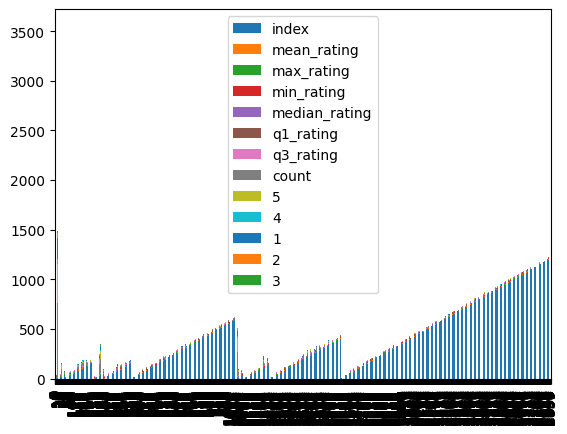

In [312]:
all_statistics_df.plot(kind='bar', stacked=True)

In [317]:
df

,1,2,3,4,5
Date,,,,,
11/01/2022,0.0,0.0,0.0,1.0,1.0
01/01/2023,0.0,0.0,0.0,0.0,1.0
02/01/2023,3.0,2.0,0.0,0.0,0.0
03/01/2023,2.0,0.0,0.0,0.0,0.0
04/01/2023,10.0,0.0,0.0,0.0,2.0
05/01/2023,5.0,0.0,0.0,0.0,0.0
06/01/2023,0.0,0.0,1.0,0.0,1.0
07/01/2023,6.0,0.0,0.0,0.0,2.0
08/01/2023,2.0,0.0,0.0,0.0,4.0


In [318]:
df = all_statistics_df.copy()
#df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", drop="True", inplace=True)
df = df[df["Category"]=='1709322143530x849396050152903400']

df = df[df["Period"]=='M']
df

,index,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,5,4,1,2,3,Period,Category,SubCategory,Grouped by
Date,,,,,,,,,,,,,,,,,
11/01/2022,0,4.500000,5,4,4.5,4.25,4.75,2,1.0,1.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
01/01/2023,1,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
02/01/2023,2,1.400000,2,1,1.0,1.00,2.00,5,0.0,0.0,3.0,2.0,0.0,M,1709322143530x849396050152903400,None,None
03/01/2023,3,1.000000,1,1,1.0,1.00,1.00,2,0.0,0.0,2.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
04/01/2023,4,1.666667,5,1,1.0,1.00,1.00,12,2.0,0.0,10.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
05/01/2023,5,1.000000,1,1,1.0,1.00,1.00,5,0.0,0.0,5.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
06/01/2023,6,4.000000,5,3,4.0,3.50,4.50,2,1.0,0.0,0.0,0.0,1.0,M,1709322143530x849396050152903400,None,None
07/01/2023,7,2.000000,5,1,1.0,1.00,2.00,8,2.0,0.0,6.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
08/01/2023,8,3.666667,5,1,5.0,2.00,5.00,6,4.0,0.0,2.0,0.0,0.0,M,1709322143530x849396050152903400,None,None


<Axes: xlabel='Date'>

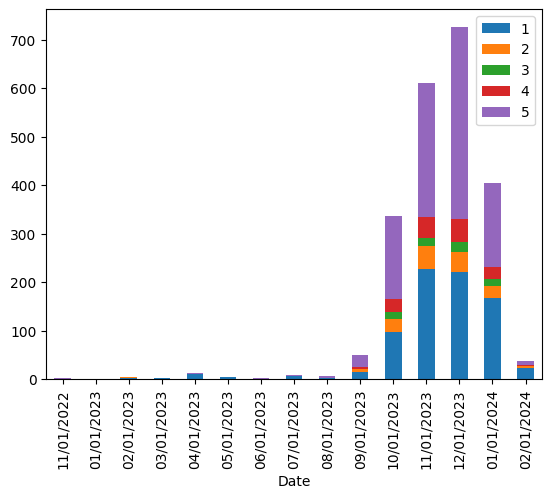

In [319]:

df = df[[1, 2, 3, 4, 5]]
df.plot(kind='bar', stacked=True)

In [330]:
df = all_statistics_df.copy()
#df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Category"]!='1709322143530x849396050152903400']
df = df[df["SubCategory"].isna()]

df = df[df["Period"]=='M']
#df.set_index(["Date", "Category"], drop="True", inplace=True)
df.set_index("Date", drop="True", inplace=True)
df = df[["count", "Category"]]
df.head().to_csv("brouillon")

<Axes: xlabel='Date'>

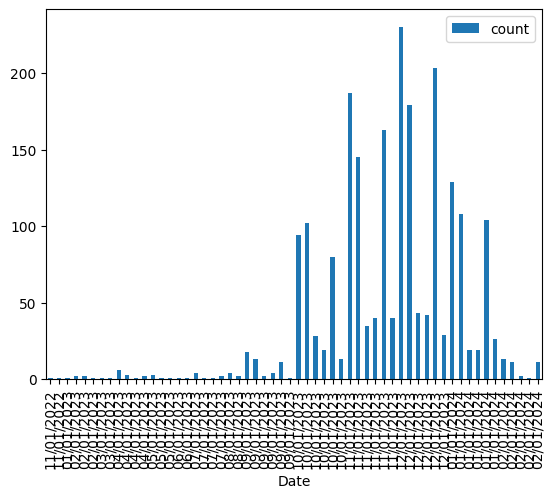

In [328]:
df = df[["count", "Category"]]
df.plot(kind='bar', stacked=True)

<Figure size 1000x600 with 0 Axes>

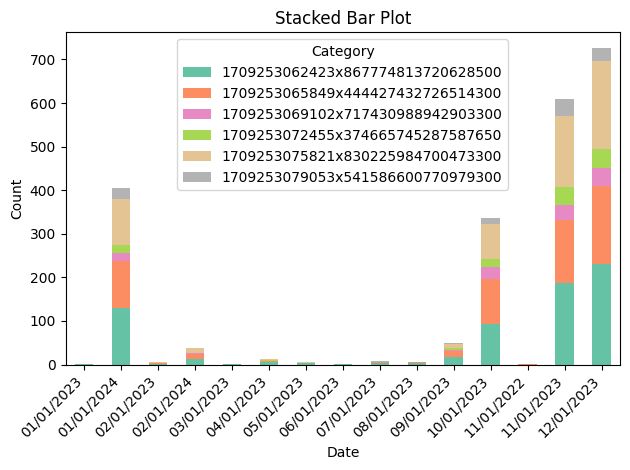

In [333]:
import matplotlib.pyplot as plt

# Reshape the data frame using pivot_table to prepare it for plotting
df_pivoted = df.pivot_table(index='Date', columns='Category', values='count', aggfunc='sum')

# Create the stacked bar plot using Matplotlib
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
df_pivoted.plot(kind='bar', stacked=True, colormap='Set2')

# Customize plot elements (optional):
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Stacked Bar Plot')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title='Category')
plt.tight_layout()

# Display the plot
plt.show()

In [310]:
X = df["Date"].drop_duplicates()

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

# data from https://allisonhorst.github.io/palmerpenguins/

species = (
    "Adelie\n $\\mu=$3700.66g",
    "Chinstrap\n $\\mu=$3733.09g",
    "Gentoo\n $\\mu=5076.02g$",
)
weight_counts = {
    "Below": np.array([70, 31, 58]),
    "Above": np.array([82, 37, 66]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

plt.show()

In [298]:
all_statistics_df[all_statistics_df["SubCategory"].isna()]

,index,Date,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,5,4,1,2,3,Period,Category,SubCategory,Grouped by
0,0,01/01/2022,4.500000,5,4,4.5,4.25,4.75,2,1.0,1.0,0.0,0.0,0.0,Y,1709322143530x849396050152903400,None,None
1,1,01/01/2023,3.328036,5,1,4.0,1.00,5.00,1762,878.0,120.0,587.0,124.0,53.0,Y,1709322143530x849396050152903400,None,None
2,2,01/01/2024,2.957111,5,1,3.0,1.00,5.00,443,182.0,27.0,191.0,28.0,15.0,Y,1709322143530x849396050152903400,None,None
3,0,11/01/2022,4.500000,5,4,4.5,4.25,4.75,2,1.0,1.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
4,1,01/01/2023,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,152,02/03/2024,1.307692,3,1,1.0,1.00,1.00,13,0.0,0.0,10.0,2.0,1.0,D,1709322143530x849396050152903400,None,None
209,153,02/04/2024,5.000000,5,5,5.0,5.00,5.00,3,3.0,0.0,0.0,0.0,0.0,D,1709322143530x849396050152903400,None,None
210,154,02/05/2024,1.000000,1,1,1.0,1.00,1.00,8,0.0,0.0,8.0,0.0,0.0,D,1709322143530x849396050152903400,None,None
211,155,02/06/2024,1.500000,2,1,1.5,1.25,1.75,2,0.0,0.0,1.0,1.0,0.0,D,1709322143530x849396050152903400,None,None


In [299]:
df = all_statistics_df.copy()
df = df[df["SubCategory"].isna()]
df["SubCategory"] = df["Category"].apply(find_empty_subcat)
res_df = all_statistics_df.copy()
res_df[res_df["SubCategory"].isna()] = df
all_statistics_df = res_df
all_statistics_df

,index,Date,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,5,4,1,2,3,Period,Category,SubCategory,Grouped by
0,0,01/01/2022,4.500000,5,4,4.5,4.25,4.75,2,1.0,1.0,0.0,0.0,0.0,Y,1709322143530x849396050152903400,1709322250500x203169341028516480,None
1,1,01/01/2023,3.328036,5,1,4.0,1.00,5.00,1762,878.0,120.0,587.0,124.0,53.0,Y,1709322143530x849396050152903400,1709322250500x203169341028516480,None
2,2,01/01/2024,2.957111,5,1,3.0,1.00,5.00,443,182.0,27.0,191.0,28.0,15.0,Y,1709322143530x849396050152903400,1709322250500x203169341028516480,None
3,0,11/01/2022,4.500000,5,4,4.5,4.25,4.75,2,1.0,1.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,1709322250500x203169341028516480,None
4,1,01/01/2023,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,1709322250500x203169341028516480,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,152,02/03/2024,1.307692,3,1,1.0,1.00,1.00,13,0.0,0.0,10.0,2.0,1.0,D,1709322143530x849396050152903400,1709322250500x203169341028516480,None
209,153,02/04/2024,5.000000,5,5,5.0,5.00,5.00,3,3.0,0.0,0.0,0.0,0.0,D,1709322143530x849396050152903400,1709322250500x203169341028516480,None
210,154,02/05/2024,1.000000,1,1,1.0,1.00,1.00,8,0.0,0.0,8.0,0.0,0.0,D,1709322143530x849396050152903400,1709322250500x203169341028516480,None
211,155,02/06/2024,1.500000,2,1,1.5,1.25,1.75,2,0.0,0.0,1.0,1.0,0.0,D,1709322143530x849396050152903400,1709322250500x203169341028516480,None


In [300]:
send_aspects(all_statistics_df)

0it [00:00, ?it/s]